# 3dasm Project

## Agenda
## Single Fidelity
- simulated data and experimental data separately
- different kernels, optimizers
## Multi Fidelity
- scikit-learn vs gpytorch
1. [Phase 1: Gaussian Process on Simulated Data only](#Phase-1:-Gaussian-Process-on-Simulated-Data-only)
2. [Phase 1.5: Gaussian Process on Experimental Data Only](#Phase-1.5:-Gaussian-Process-on-Experimental-Data-Only)
3. [Phase 2: Training with Simulation Data and Testing with Experimental Data](#Phase-2:-Training-with-Simulation-Data-and-Testing-with-Experimental-Data)
4. [Phase 3: Multi-fidelity Gaussian Process](#Phase-3:-Multi-fidelity-Gaussian-Process)
5. [Phase 4: Error Metrics](#Phase-4:-Error-Metrics)

### Importing necessary packages

In [2]:
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math
import pandas as pd

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

<a id='Phase 1: Gaussian Process on Simulated Data only'></a>

## Phase 1: Gaussian Process on Simulated Data only

In [3]:
sim_df = pd.read_csv("../less_points_Simulation_Data_0.05_13900.csv") # read pandas DataFrame
print("Show the simulated DataFrameused for training data:\n", sim_df)

Show the simulated DataFrameused for training data:
             0         1
0    0.075682  0.995894
1    0.181336  0.977851
2    0.286990  0.944549
3    0.378912  0.901576
4    0.453920  0.855101
..        ...       ...
464  4.782890  0.157443
465  4.830016  0.156129
466  4.877141  0.154620
467  4.924266  0.153483
468  4.971392  0.153081

[469 rows x 2 columns]


In [4]:
Data_x_sim = sim_df.iloc[:,0] # select the input VALUES from your dataframe into Data_x
Data_y_sim = sim_df.iloc[:,1] # select the output VALUES from your dataframe inta Data_y
print("Data_x is:\n",Data_x_sim)
print("\nData_y is:\n",Data_y_sim)

Data_x is:
 0      0.075682
1      0.181336
2      0.286990
3      0.378912
4      0.453920
         ...   
464    4.782890
465    4.830016
466    4.877141
467    4.924266
468    4.971392
Name: 0, Length: 469, dtype: float64

Data_y is:
 0      0.995894
1      0.977851
2      0.944549
3      0.901576
4      0.855101
         ...   
464    0.157443
465    0.156129
466    0.154620
467    0.153483
468    0.153081
Name: 1, Length: 469, dtype: float64


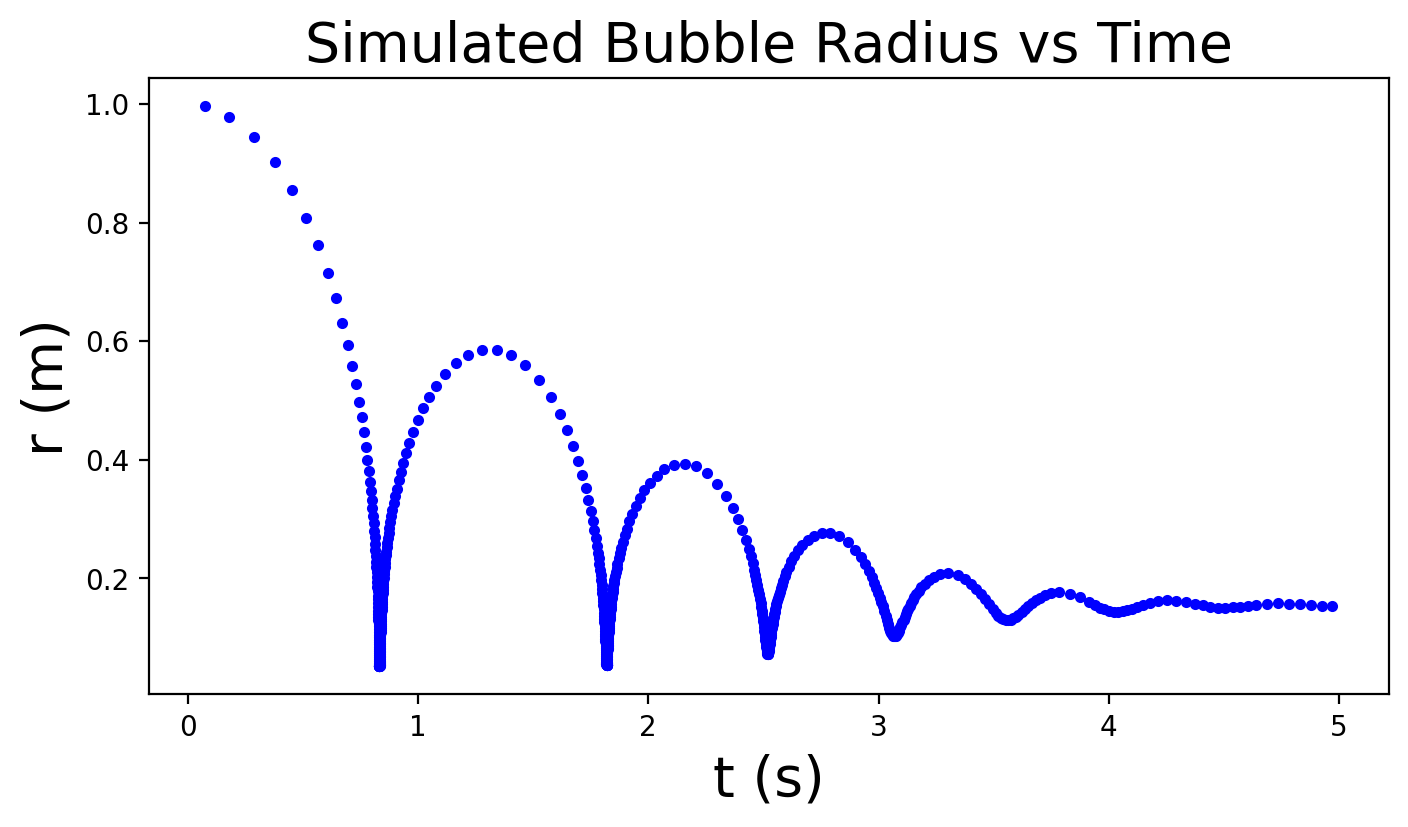

In [5]:
fig_sim_data, ax_sim_data = plt.subplots() # create a plot
ax_sim_data.plot(Data_x_sim, Data_y_sim, 'b.')
ax_sim_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20
ax_sim_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20
ax_sim_data.set_title("Simulated Bubble Radius vs Time", fontsize=20); # create title with font size 20
plt.show(fig_sim_data)

In [55]:
from sklearn.model_selection import train_test_split

n_data = 50 # number of points in our dataset
testset_ratio = 0.10 # ratio of test set points from the dataset

X_data_sim = np.reshape(Data_x_sim,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_data_sim,
                                    Data_y_sim, test_size=testset_ratio,
                                    random_state=seed)

x_train_sim = X_train_sim.ravel() # just for plotting later
x_test_sim = X_test_sim.ravel() # just for plotting later

In [56]:
# Define points used for plotting
n_max_sim = np.max(X_data_sim)
n_min_sim = np.min(X_data_sim)
n_plot = 500 # number of points used for plotting the model
x_plot_sim = np.linspace(n_min_sim, n_max_sim, n_plot) # create dataset with uniformly spaced points
X_plot_sim = np.reshape(x_plot_sim,(-1,1)) # a 2D array that scikit-learn likes

/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


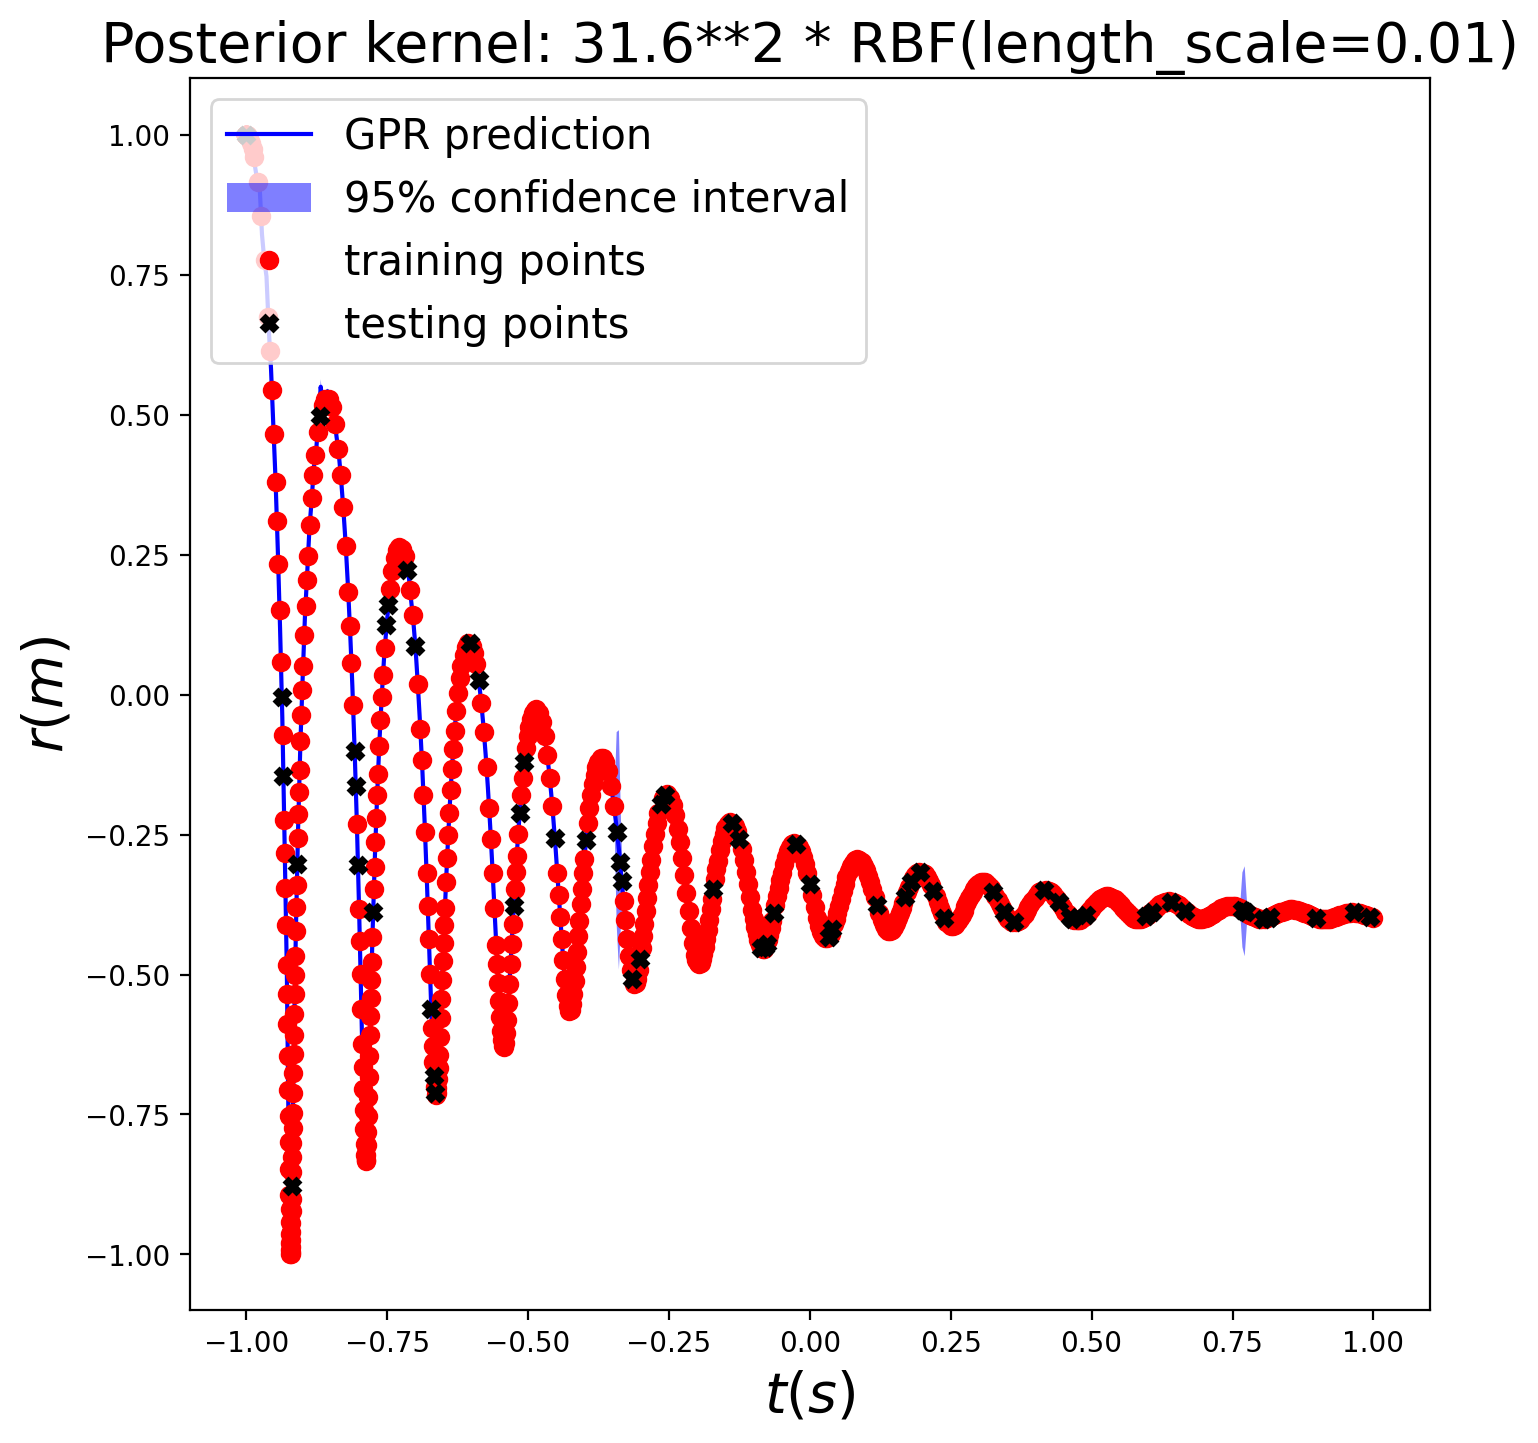

In [57]:
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

#intiate the low fidelity GP mode
#LF_GP = GPInterpolator()

LF_gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

# Fit to data to determine parameters
LF_gp_model.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = LF_gp_model.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = LF_gp_model.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t (s)$', fontsize=20)
ax1.set_ylabel('$r (m)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % LF_gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)

<h id='Phase 1.5: Gaussian Process on Experimental Data Only'></h>

# Phase 1.5: Gaussian Process on Experimental Data Only

In [9]:
exp_df = pd.read_csv("../normalized_unscaled_Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame
print("Show the experimental DataFrame used for testing data:\n", exp_df)

Show the experimental DataFrame used for testing data:
      0.0170220398718178  0.999866408529248
0              0.044679           0.998759
1              0.072336           0.996847
2              0.099993           0.994077
3              0.127651           0.990380
4              0.155308           0.985505
..                  ...                ...
176            4.912334           0.163639
177            4.939991           0.159946
178            4.967648           0.156486
179            4.995306           0.154681
180            5.022963           0.155009

[181 rows x 2 columns]


In [10]:
Data_t_exp = exp_df.iloc[:,0]
Data_R_exp = exp_df.iloc[:,1] 
#Data_R2_exp = exp_df.iloc[:,2] 
print("Experimental x data is time:\n",Data_t_exp)
print("Experimental Bubble Radius from camera one is:\n",Data_R_exp)
#print("Experimental Bubble Radius from camera two is:\n",Data_R2_exp)

Experimental x data is time:
 0      0.044679
1      0.072336
2      0.099993
3      0.127651
4      0.155308
         ...   
176    4.912334
177    4.939991
178    4.967648
179    4.995306
180    5.022963
Name: 0.0170220398718178, Length: 181, dtype: float64
Experimental Bubble Radius from camera one is:
 0      0.998759
1      0.996847
2      0.994077
3      0.990380
4      0.985505
         ...   
176    0.163639
177    0.159946
178    0.156486
179    0.154681
180    0.155009
Name: 0.999866408529248, Length: 181, dtype: float64


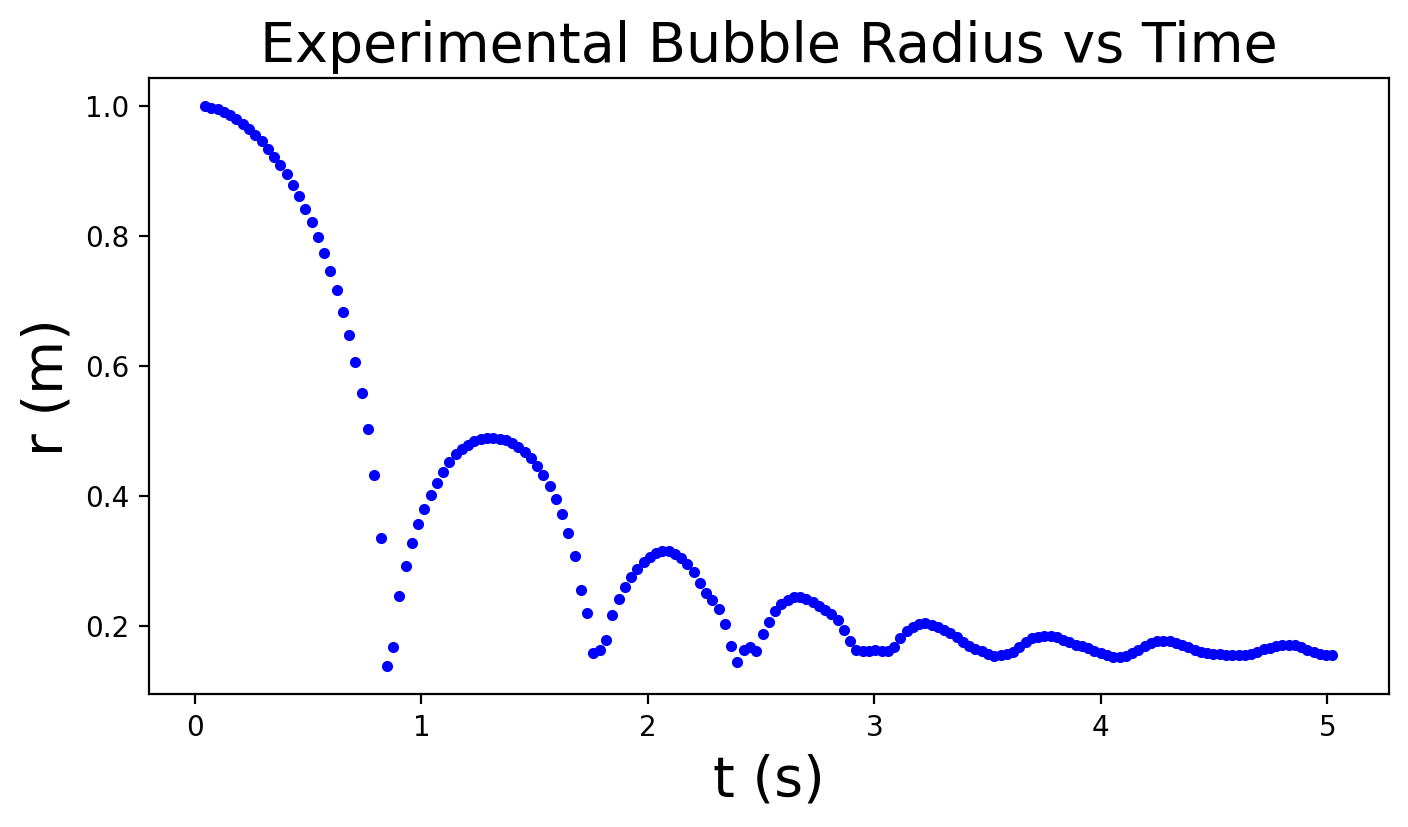

In [22]:
fig_exp_data, ax_exp_data = plt.subplots() # create a plot
ax_exp_data.plot(Data_t_exp, Data_R_exp, 'b.')
ax_exp_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20
ax_exp_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20
ax_exp_data.set_title("Experimental Bubble Radius vs Time", fontsize=20); # create title with font size 20
plt.show(fig_exp_data)

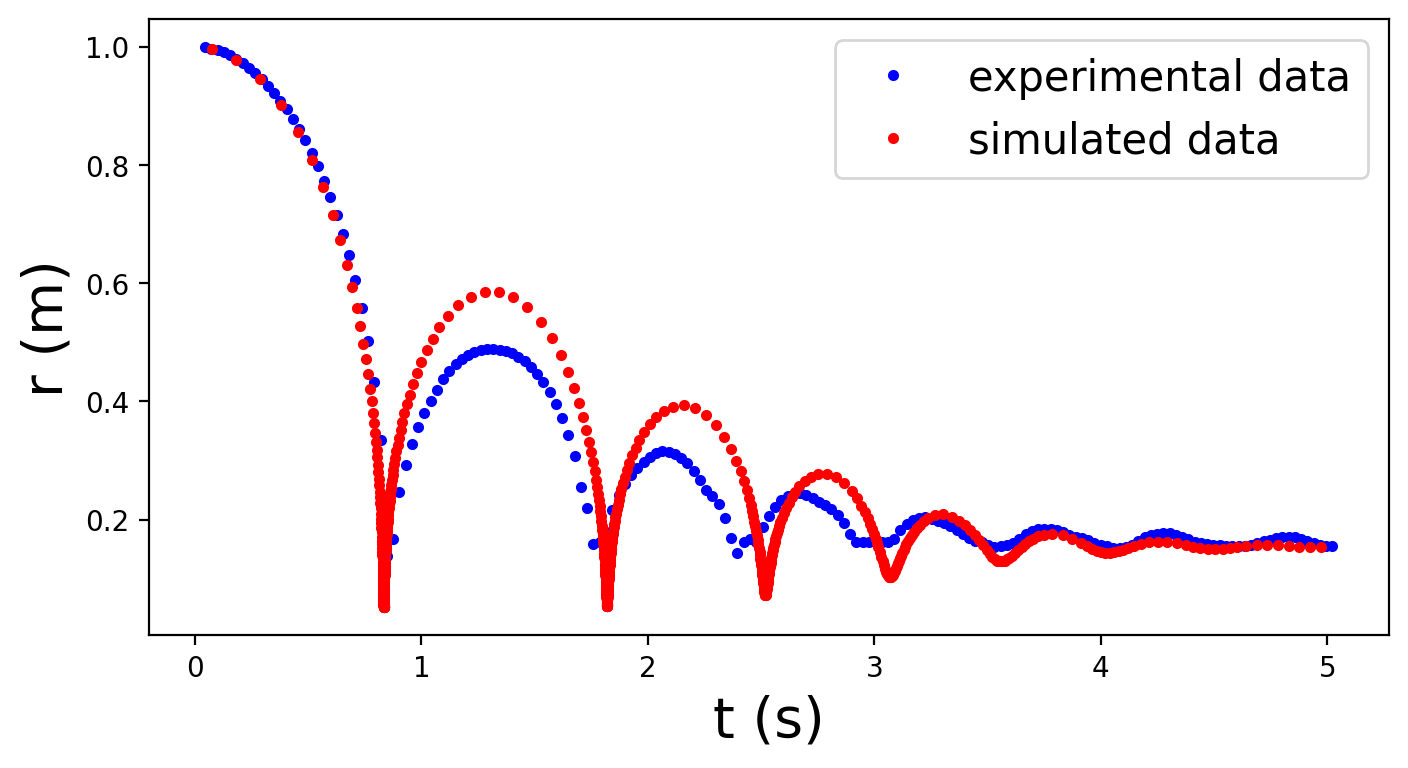

In [26]:

fig_data, ax_data = plt.subplots() # create a plot
ax_data.plot(Data_t_exp, Data_R_exp, 'b.',label="experimental data")
ax_data.plot(Data_x_sim, Data_y_sim, 'r.',label="simulated data")

ax_data.set_xlabel("t (s)", fontsize=20) # create x-axis label with font size 20

ax_data.set_ylabel("r (m)", fontsize=20) # create y-axis label with font size 20

#handles, labels = ax_data.get_legend_handles_labels()
#ax_data.legend(handles, labels)
ax_data.legend(loc='upper right', fontsize=15)
plt.show(fig_data)

In [61]:
n_data = len(Data_t_exp) # number of points in our dataset
testset_ratio = 0.75 # ratio of test set points from the dataset

t_data_exp = np.reshape(Data_t_exp,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(t_data_exp,
                                    Data_R_exp, test_size=testset_ratio,
                                    random_state=seed)

x_train_exp = X_train_exp.ravel() # just for plotting later
x_test_exp = X_test_exp.ravel() # just for plotting later

In [62]:
# Define points used for plotting
n_max_exp = np.max(t_data_exp)
n_min_exp = np.min(t_data_exp)
n_plot = 500 # number of points used for plotting the model
x_plot_exp = np.linspace(n_min_exp, n_max_exp, n_plot) # create dataset with uniformly spaced points
X_plot_exp = np.reshape(x_plot_exp,(-1,1)) # a 2D array that scikit-learn likes

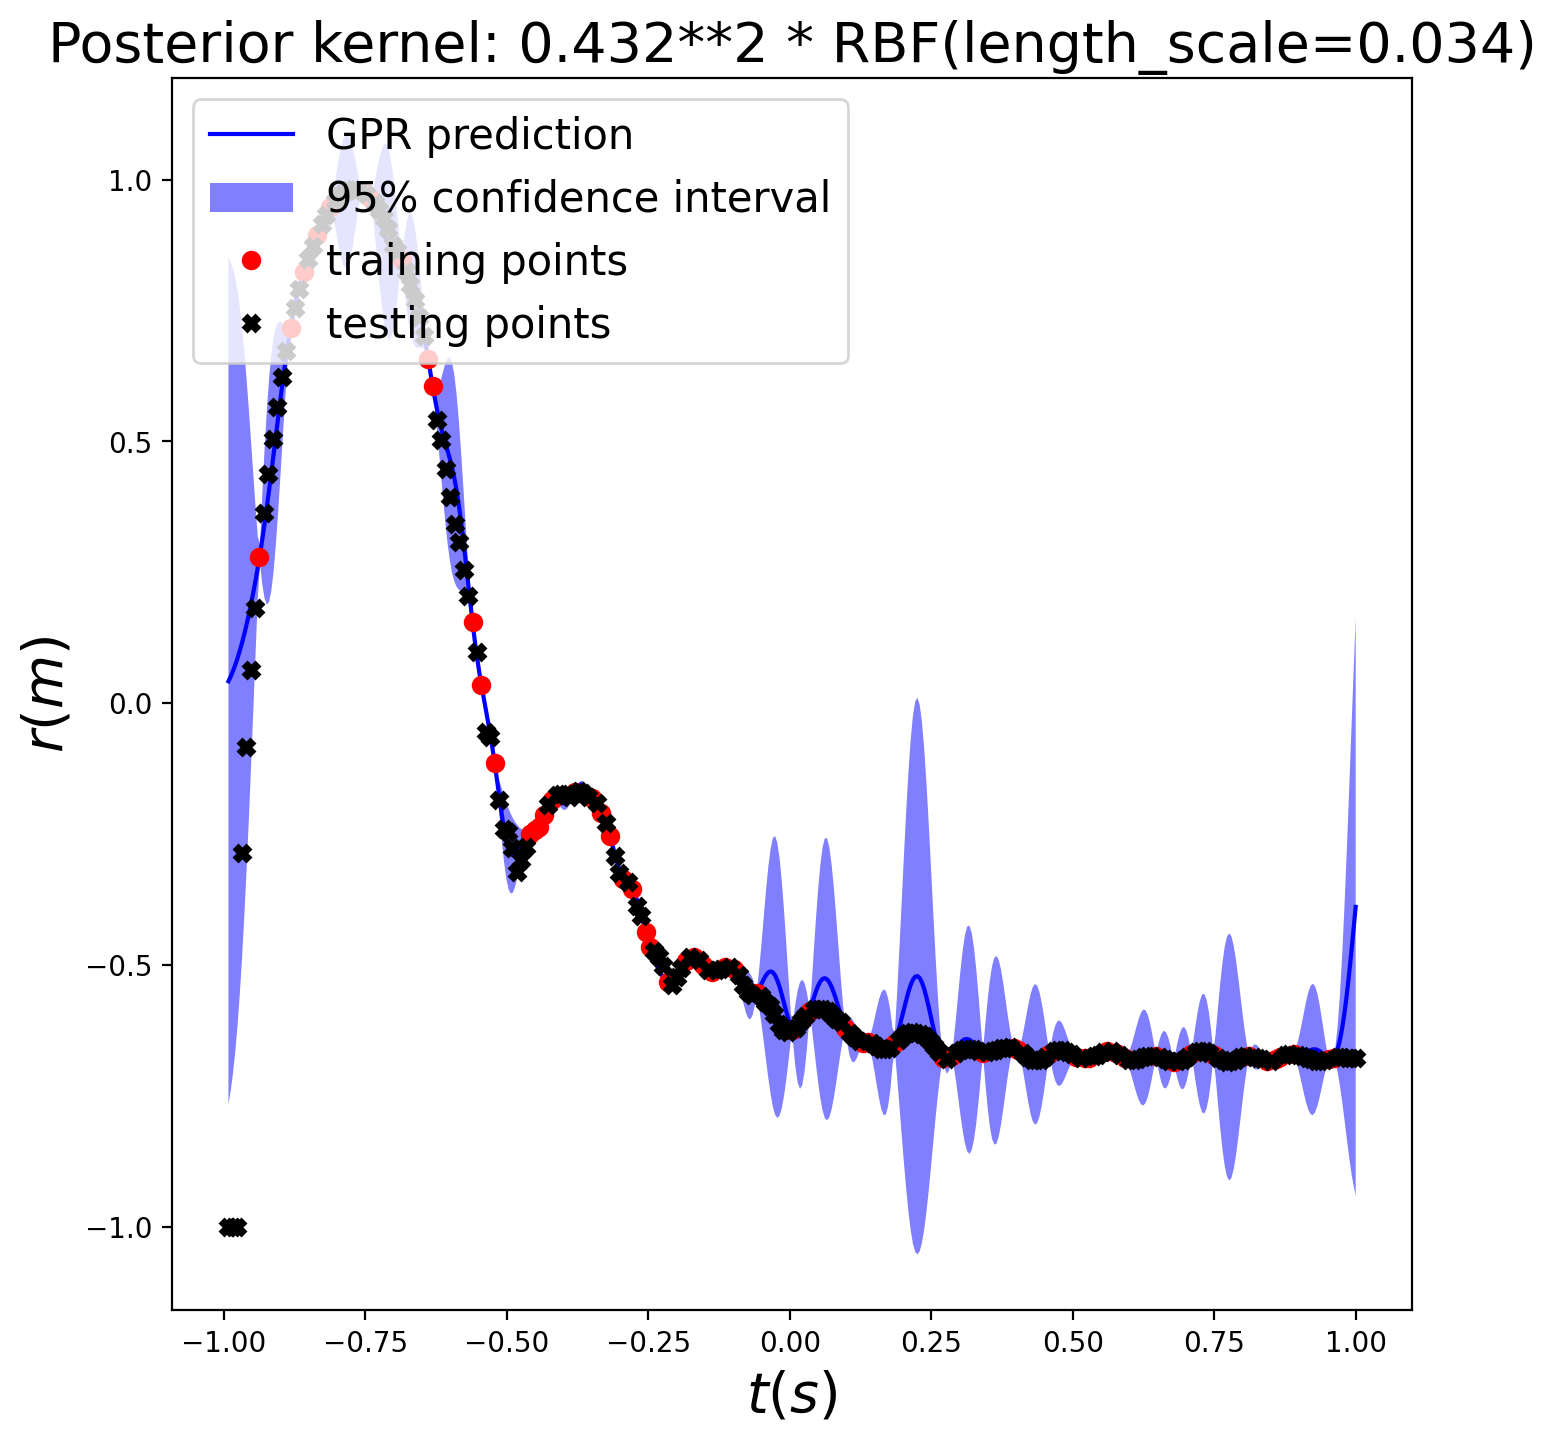

In [63]:
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

#initiate a high fidelity GP model
# HF_GP = GPInterpolator()

HF_gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

# Fit to data to determine parameters
HF_gp_model.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = HF_gp_model.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = HF_gp_model.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t (s)$', fontsize=20)
ax1.set_ylabel('$r (m)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % HF_gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)

<c id='Phase 2: Training with Simulation Data and Testing with Experimental Data'></c>

# Phase 2: Multi-fidelity Gaussian Process
## Scikit-learn: Training with Simulation Data and Testing with Experimental Data

In [64]:
# training data = (low fidelity) simulation data, test data = (high fidelity) experimental data

# defining training data
X_train_LF = X_data_sim # a 2D array that scikit-learn likes, for simulated data
y_train_LF = Data_y_sim

# defining test data
X_test_HF = t_data_exp
y_test_HF = Data_R_exp

n_data = len(Data_t_exp) # number of points in our dataset
#testset_ratio = len(X_train)/len(Data_t_exp) # ratio of test set points from the datasets

x_train_LF = X_train_LF.ravel() # just for plotting later
x_test_LF = X_test_HF.ravel() # just for plotting later

print(len(X_train_LF))
print(len(y_train_LF))

print(len(X_test_HF))
print(len(y_test_HF))

# Define points used for plotting
n_max_MF = np.max(X_train_LF)
n_min_MF = np.min(X_train_LF)
n_plot = 500 # number of points used for plotting the model
x_plot_MF = np.linspace(n_min_MF, n_max_MF, n_plot) # create dataset with uniformly spaced points
X_plot_MF = np.reshape(x_plot_MF,(-1,1)) # a 2D array that scikit-learn likes

684
684
255
255


In [74]:
#import GP interpolation module
from GPInterpolator import GPInterpolator

#calculating trend terms (9: https://gitlab.lrz.de/tfd/howtogaussianprocess/-/blob/master/tutorial/GP_Multi-fidelity.ipynb)
LF_trend, LF_std  = LF_gp_model.predict(X_train_LF,return_std=True) #training GP model in LF TRAINING DATA? LF_trend, _ = LF_gp_model.predict(t_data_exp)

# Define the kernel function
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

#initiate a GP model
multi_GP = GPInterpolator(trend=LF_trend.reshape(-1,1))
#LF_gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

#fit a multi-fidelity GP model
multi_GP.fit(t_data_exp,Data_R_exp)

#calculating trend terms
LF_pred_trend, LF_pred_std = LF_GP.predict(X_test_HF,return_std=True)

#GP Predictions
MF_pred, _ = multi_GP.predict(X_test_HF,trend = LF_pred_trend.reshape(-1,1))


# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t (s)$', fontsize=20)
ax1.set_ylabel('$r (m)$', fontsize=20)
ax1.set_title("Posterior kernel: %s"
              % LF_gp_model.kernel_, fontsize=20) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)

ModuleNotFoundError: No module named 'GPInterpolator'

<c id='Phase 3: Multi-fidelity Gaussian Process'></c>

# Phase 3: Multi-fidelity Gaussian Process
## GPyTorch Regression for Experimental and Simulated Bubble Dynamics

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Setting up Training and Testing Data
train_x = torch.Tensor(x_train)
train_y = torch.Tensor(y_train)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
input_tensor = train_x.view(-1, 1)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
import torch.optim as optim

# ... (previous code)

# Initialize the LBFGS optimizer
optimizer = optim.LBFGS(model.parameters(), lr=0.1)

# Define the closure function for LBFGS optimization
def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    return loss

# Run LBFGS optimization
for i in range(training_iter):
    optimizer.step(closure)
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, closure().item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(test_x))

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1.0, 1.0])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Setting up Training and Testing Data
train_x = torch.Tensor(x_train)
train_y = torch.Tensor(y_train)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
input_tensor = train_x.view(-1, 1)

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1.0, 1.0])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Assuming you have created your GP model and likelihood (model and likelihood are instances of GPyTorch modules)
from scipy.optimize import fmin_l_bfgs_b

# Flatten the model parameters to a 1D vector
initial_params = np.concatenate([param.flatten().detach().numpy() for param in model.parameters()])

# Define the objective function
def objective(params):
    # Convert the 1D parameter vector back to the model parameters
    start_index = 0
    for param in model.parameters():
        end_index = start_index + param.numel()
        param.data = torch.Tensor(params[start_index:end_index]).view(param.shape)
        start_index = end_index
    
    # Output from model
    observed_pred = model(test_x)
    
    # Calculate the negative log likelihood
    nll = -gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)(observed_pred, train_y
    
    return nll.item()

# Optimize using fmin_l_bfgs_b
optimized_params, _, _ = fmin_l_bfgs_b(objective, initial_params)

# Update the model parameters with the optimized values
start_index = 0
for param in model.parameters():
    end_index = start_index + param.numel()
    param.data = torch.Tensor(optimized_params[start_index:end_index]).view(param.shape)
    start_index = end_index

# The model has been updated with the optimized parameters

In [ ]:
#botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

#fit model
train_X = torch.rand(10, 2)
Y = 1 - torch.linalg.norm(train_X - 0.5, dim=-1, keepdim=True)
Y = Y + 0.1 * torch.randn_like(Y)  # add some noise
train_Y = standardize(Y)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

In [ ]:
#construct acquisition function
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

In [ ]:
#optimize acquisition function
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate  # tensor([0.4887, 0.5063])

<p id='Phase 4: Comparing Error Metrics'></p>

# Phase 4: Comparing Error Metrics

### # Phase 5: Different Materials? More data files? Different shear moduli/viscosity (hyperparameters?)
## Slides (12) for presentation: 2 GP (M), 4 data-assim (V), 4 - multi-fidelity (M), 2 - ? (V)
### want understanding: why chose those algorithms, compare algorithms, explain new methods used

# Things to Do
- [12/01] use new experimental data from Bachir (10%/0.06% PA/BIS)
- [12/01] scale new experimental data ?
- [12/01] change simulated data that this notebook takes to be the one that corresponds most closely to the G and mu of Bachir's exp data
- change f_min optimizer to be lgbs in scikit-learn side and in gpytorch side
- duplicate gpytorch in multiple kernels to compare with scikit-learn
- go back and add error metrics for all GP algorithms, catalog and compare, do for both experimental and simulated data?
- better understand multitask GP Regression and try to implement
- if have time, try fully bayesian GP to sample hyperparameters